INFO:
<class 'pandas.core.frame.DataFrame'>
Index: 3403 entries, 1367 to 856
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3403 non-null   int64  
 1   gender             3403 non-null   object 
 2   age                3403 non-null   float64
 3   hypertension       3403 non-null   int64  
 4   heart_disease      3403 non-null   int64  
 5   ever_married       3403 non-null   object 
 6   work_type          3403 non-null   object 
 7   Residence_type     3403 non-null   object 
 8   avg_glucose_level  3403 non-null   float64
 9   bmi                3259 non-null   float64
 10  smoking_status     3403 non-null   object 
 11  stroke             3403 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 345.6+ KB

DESCRIBE:
                 id          age  hypertension  heart_disease  \
count   3403.000000  3403.000000   3403.000000    3403.000000   
mean   36433.

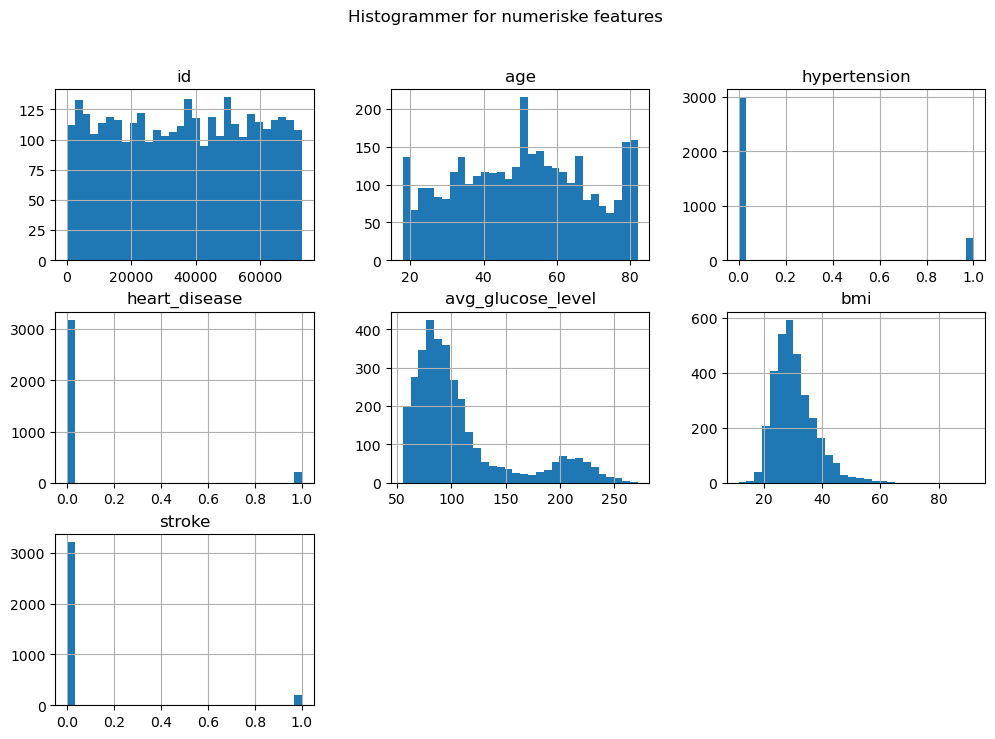

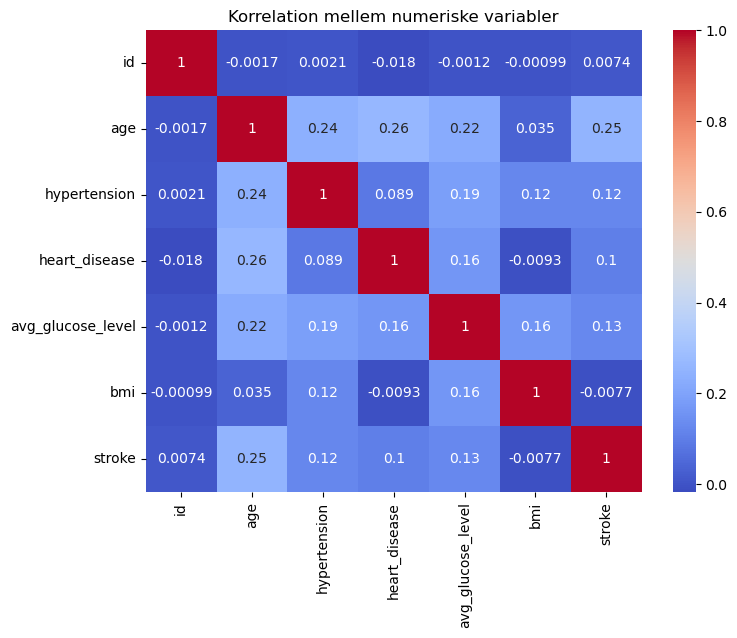


Manglende v√¶rdier:
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  144
smoking_status         0
stroke                 0
dtype: int64


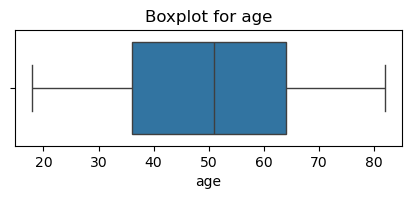

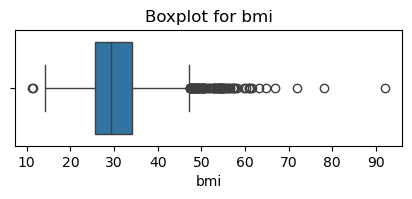

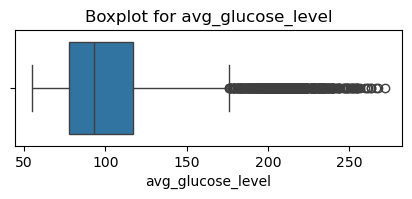

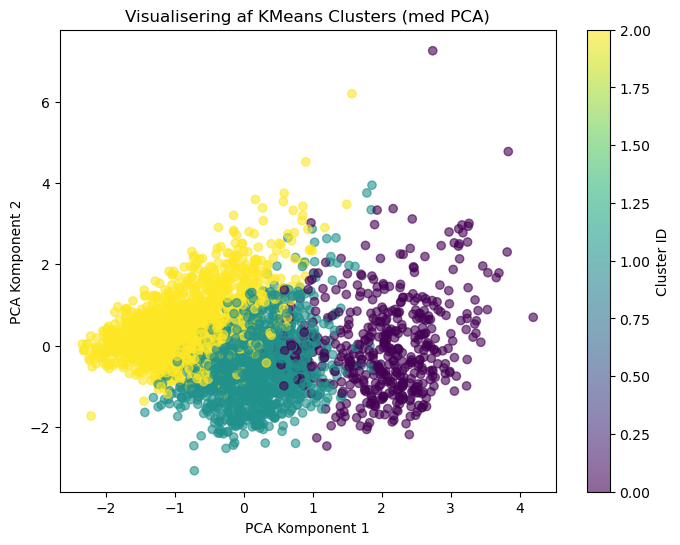


Shape efter transformation: (3259, 21)

üîç Logistic Regression
RMSE pr fold: [0.51062334 0.53982501 0.56887576 0.52978755 0.554274  ]
Gennemsnitlig RMSE: 0.540677131560118
Standardafvigelse: 0.020012880299431657

üîç Random Forest
RMSE pr fold: [0.2283577  0.23497813 0.23821937 0.2283577  0.22853302]
Gennemsnitlig RMSE: 0.23168918484350662
Standardafvigelse: 0.004138100876893

üîç KNN
RMSE pr fold: [0.23497813 0.2283577  0.23497813 0.23169157 0.23186945]
Gennemsnitlig RMSE: 0.23237499675547096
Standardafvigelse: 0.0024663327571844917
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

 Bedste parametre fundet:
{'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}

 Klassifikationsrapport p√• tr√¶ningsdata:
[[2957  135]
 [  15  152]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      3092
           1       0.53      0.91      0.67       167


In [5]:
# -------------------------------
# AI-25 Exam project Storke Prediction
# Step 1: Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix



#Import alle de 3 modeller vi skal bruge samt vores score 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

#KMeans import
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Import af Gridesearch 
from sklearn.model_selection import GridSearchCV

# -------------------------------
# Step 2: Load Full Data
# -------------------------------
# S√∏rg for at 'healthcare-dataset-stroke-data.csv' er i samme mappe
full_data = pd.read_csv(r"C:\Users\moham\OneDrive\Datamatiker\OneDrive\Skrivebord\CPHBusniss\Software Developer\Semester 2\AI og ML\AI\EksamenProject\Exam Project Part 1\healthcare-dataset-stroke-data.csv")


# -------------------------------
# Step 3: Stratified Train/Test/Rensning & Split (20% test based on 'stroke')
# -------------------------------

# Rens datas√¶ttet: fjern personer under 18 √•r
full_data = full_data[full_data["age"] >= 18].reset_index(drop=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(full_data, full_data["stroke"]):
    strat_train_set = full_data.loc[train_index]
    strat_test_set = full_data.loc[test_index]

# Brug kun tr√¶ningss√¶ttet fra nu af
data = strat_train_set.copy()

# 4.1 ‚Äì Info om datatype og manglende v√¶rdier
print("INFO:")
data.info()

# 4.2 ‚Äì Statistisk oversigt over numeriske kolonner
print("\nDESCRIBE:")
print(data.describe())

# 4.3 ‚Äì V√¶rdifordeling i kategoriske features
print("\nVALUE COUNTS:")
print("Sex:\n", data["gender"].value_counts(), "\n")
print("Ever Married:\n", data["ever_married"].value_counts(), "\n")
print("Work Type:\n", data["work_type"].value_counts(), "\n")
print("Residence Type:\n", data["Residence_type"].value_counts(), "\n")
print("Smoking Status:\n", data["smoking_status"].value_counts(), "\n")

# 4.4 ‚Äì Histogrammer for numeriske features
data.hist(bins=30, figsize=(12, 8))
plt.suptitle("Histogrammer for numeriske features")
plt.show()

# 4.5 ‚Äì Korrelation mellem numeriske features
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Korrelation mellem numeriske variabler")
plt.show()

# 4.6 ‚Äì Manglende v√¶rdier
print("\nManglende v√¶rdier:")
print(data.isnull().sum())

# 4.7 ‚Äì Boxplots for outliers
for col in ["age", "bmi", "avg_glucose_level"]:
    plt.figure(figsize=(5, 1.5))
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

# -------------------------------
# Step 5: Forberedelse af data
# -------------------------------

# 1. Byg numerisk_pipeline for hver type data
numerisk_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# 1A. Identific√©r feature-typer i stroke-datas√¶ttet
numeriske_attributter = ["age", "avg_glucose_level", "bmi"]
kategoriske_attributter = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status", "KMeans_cluster"]

# 2 ‚Äì Ops√¶tning af KMeans Feature Engineering
X_kmeans = data[numeriske_attributter].copy()
X_kmeans_clean = X_kmeans.dropna()   # Drop NaN for at undg√• fejl i KMeans og gem indekser
X_kmeans_prepared = numerisk_pipeline.fit_transform(X_kmeans_clean)
data = data.loc[X_kmeans_clean.index].reset_index(drop=True) # Begr√¶ns data til de samme r√¶kker der bruges i clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # K√∏r KMeans clustering
data["KMeans_cluster"] = kmeans.fit_predict(X_kmeans_prepared).astype(str)

#2A Visualisering af KMeans clusters vha. PCA
X_pca = PCA(n_components=2).fit_transform(X_kmeans_prepared)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap="viridis", alpha=0.6)
plt.title("Visualisering af KMeans Clusters (med PCA)")
plt.xlabel("PCA Komponent 1")
plt.ylabel("PCA Komponent 2")
plt.colorbar(label="Cluster ID")
plt.show()

# 3. Defin√©r input (X) og m√•lvariabel (y)
X_train = data.drop("stroke", axis=1)
y_train = data["stroke"]


# . Byg kategorisk_pipeline for hver type data
kategorisk_pipeline = Pipeline([
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

# 4. Kombin√©r begge i en samlet pipeline
full_pipeline = ColumnTransformer([
    ("num", numerisk_pipeline, numeriske_attributter),
    ("cat", kategorisk_pipeline, kategoriske_attributter)
])

# 5. Transform√©r X_train
X_prepared = full_pipeline.fit_transform(X_train)

# Valgfrit: print form
print("\nShape efter transformation:", X_prepared.shape)

# -------------------------------
# Step 6: Tr√¶n og sammenlign modeller (shortlisting)

# 1. Liste over modeller vi vil teste
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=1000),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
    "KNN": KNeighborsClassifier()
}

# 2. Test hver model med 5-fold cross-validation
for name, model in models.items():
    print(f"\nüîç {name}")
    
    # Brug negativ MSE for konsistens med scoring (neg_mean_squared_error ‚Üí lavere er bedre)
    scores = cross_val_score(model, X_prepared, y_train, scoring="neg_mean_squared_error", cv=5)
    rmse_scores = np.sqrt(-scores)
    
    print("RMSE pr fold:", rmse_scores)
    print("Gennemsnitlig RMSE:", rmse_scores.mean())
    print("Standardafvigelse:", rmse_scores.std())

# Step 7: Fine-tune Random Forest med GridSearchCV

# 1. Byg modelinstans
forest_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# 2. Defin√©r parametergrid (uden 'auto' i max_features)
param_grid = {
    'n_estimators': [100, 200, 300],              # Flere tr√¶er for stabilitet
    'max_depth': [None, 10, 20, 30],              # Begr√¶nset tr√¶dybde kan mindske overfitting
    'max_features': ['sqrt', 'log2'],             # Standardvalg i Random Forest
    'min_samples_split': [2, 5, 10],              # Flere splits kan g√∏re modellen mere generaliserbar
    'min_samples_leaf': [1, 2, 4],                # Mindre risiko for overfitting ved st√∏rre blade
    'bootstrap': [True]                           # Bootstrap = anbefalet ved regression
}

# 3. Ops√¶t GridSearchCV
grid_search = GridSearchCV(
    estimator=forest_clf,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=2,
    n_jobs=-1
)

# 4. Tr√¶n og find bedste parametre
grid_search.fit(X_prepared, y_train)

# 5. Vis resultater
print("\n Bedste parametre fundet:")
print(grid_search.best_params_)

# 6. Gem den bedste model
best_model = grid_search.best_estimator_

# 7. Evaluer model med klassifikationsmetrikker p√• tr√¶ningsdata
y_train_pred = best_model.predict(X_prepared)
print("\n Klassifikationsrapport p√• tr√¶ningsdata:")
print(confusion_matrix(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))


# -------------------------------
# Step 8: Evalu√©r p√• test data (dvs. de 20% ) (med KMeans_cluster)
# -------------------------------

# 1. Forbered testdata: adskil X og y
y_test = strat_test_set["stroke"]

# 2. Tilf√∏j KMeans_cluster til testdata (baseret p√• samme pipeline og model som tr√¶ning)
X_test_kmeans = strat_test_set[numeriske_attributter].copy()
X_test_kmeans_prepared = numerisk_pipeline.transform(X_test_kmeans)
X_test_clusters = kmeans.predict(X_test_kmeans_prepared).astype(str)

# 3. Opret X_test med cluster-feature inkluderet
X_test = strat_test_set.copy()
X_test["KMeans_cluster"] = X_test_clusters

# 4. Transform√©r X_test med den samme pipeline som i tr√¶ning
X_test_prepared = full_pipeline.transform(X_test)

# 5. Brug den bedste model til at forudsige
final_predictions = best_model.predict(X_test_prepared)

# 6. Klassifikationsevaluering
print("üìä Endelig evaluering p√• test-s√¶t:")
print("Confusion Matrix:\n", confusion_matrix(y_test, final_predictions))
print("\nClassification Report:\n", classification_report(y_test, final_predictions))

# -------------------------------
# Step 9: Gem pipeline og model til brug i applikation
# -------------------------------

# Gem den f√¶rdige pipeline og model
joblib.dump(full_pipeline, "Exam_pipeline.pkl")
joblib.dump(best_model, "Exam_model.pkl")
joblib.dump(kmeans, "kmeans_model.pkl") 
print("‚úÖ Pipeline, model og Kmeans er gemt som 'Exam_pipeline.pkl' & 'Exam_model.pkl' &'kmeans_model.pkl'")



***A: Frame the Problem***

Vi har valgt at arbejde med emnet "slagtilf√¶lde", som er en medicinsk tilstand og en af de f√∏rende d√∏ds√•rsager p√• verdensplan. Derfor vil vi udvikle et v√¶rkt√∏j, der kan hj√¶lpe med at screene patienter og forudsige, om de har en potentiel risiko for at f√• en hjernebl√∏dning, baseret p√• forskellige helbreds- og livsstilsfaktorer som alder, blodglukoseniveau, BMI, k√∏n, rygestatus og mere.

Forretningsm√•let er at udvikle et v√¶rkt√∏j, der kan hj√¶lpe sundhedspersonale med at forudsige, om en patient tilh√∏rer en risikogruppe for at f√• et slagtilf√¶lde. Form√•let er at muligg√∏re tidlig indsats og forebyggende behandling, som i sidste ende kan redde liv.

Det, vi √∏nsker at forudsige, er en bin√¶r m√•lvariabel, hvor stroke har v√¶rdien 0 eller 1. Da datas√¶ttet er ubalanceret, er det vigtigt at v√¶re omhyggelig i valget af model. Derfor har vi valgt at bruge klassifikationsmodeller fremfor regressionsmodeller. Vi evaluerer resultaterne med klassifikationsmetrikker som F1-score, precision, recall og confusion matrix.


---

***B: Get the data***

‚Ä¢ Gem en kopi af test-s√¶ttet (fx 20%) ‚Äì brug StratifiedShuffleSplit

Vi arbejder med datas√¶ttet "Stroke Prediction Dataset" fra Kaggle. Det indeholder 5110 personer med sundhedsoplysninger.

M√•lvariablen er stroke, som angiver hvorvidt en person har f√•et et slagtilf√¶lde (1) eller ej (0). De √∏vrige kolonner omfatter blandt andet:

* gender: Mand/kvinde/andet

* age: Alder i √•r

* hypertension: H√∏jt blodtryk (0/1)

* heart_disease: Hjertesygdom (0/1)

* ever_married: Har personen v√¶ret gift

* work_type: Type af arbejde (private, public, children osv.)

* Residence_type: Urban eller rural

* avg_glucose_level: Gennemsnitligt blodsukkerniveau

* bmi: Body Mass Index

* smoking_status: Rygervaner

* stroke: M√•lvariabel

Vi stratificerede vores split baseret p√• stroke, da datas√¶ttet er meget ubalanceret (ca. 5% har haft slagtilf√¶lde). Det sikrer, at b√•de tr√¶nings- og test-s√¶t indeholder en repr√¶sentativ fordeling af positive og negative cases. Det er vigtigt for at f√• en fair model.

Vi har gemt test-s√¶ttet (20%) og bruger kun tr√¶ningsdata (80%) til al dataanalyse, forberedelse og modeltr√¶ning. Test-s√¶ttet bliver f√∏rst brugt sidst til den endelige evaluering af modellen.


**Vigtigt Info:**  Det er vigtigt at holde test-s√¶ttet "rent", s√• vi ikke overfitter og kan evaluere √¶rligt.

**For at resette:** N√•r vi pr√∏ver flere modeller, opretter vi nye instanser for at starte forfra uden tidligere tr√¶ning.

**Vi gemmer vores model:** Den endelige model og pipeline bliver gemt med joblib, s√• den kan genbruges fx i en app eller pr√¶sentation.



---

***C: Explore the data***

Brug .info(), .describe() og visualiseringer for at forst√• datastrukturen og fordelingen
Identific√©r urealistiske v√¶rdier, manglende v√¶rdier og outliers

Vi startede med at unders√∏ge datas√¶ttet for generelle m√∏nstre og fejl. Det viste sig, at datas√¶ttet ligner et auto-genereret syntetisk s√¶t og indeholder urealistiske kombinationer, fx personer p√• 0‚Äì17 √•r der arbejder, gift og har haft slagtilf√¶lde.

For at rydde op i datas√¶ttet valgte vi at fjerne alle personer under 18 √•r (age < 18), da det ikke er realistisk, at b√∏rn arbejder eller har h√∏j risiko for stroke i dette datas√¶t.

Ved hj√¶lp af .info() og .isnull().sum() kunne vi se, at bmi havde nogle manglende v√¶rdier. Disse h√•ndterede vi senere med en SimpleImputer, som udfylder dem med medianen. Det er en robust strategi, der beskytter mod outliers.

Vi brugte .describe() til at analysere de numeriske kolonner og lavede histogrammer og boxplots for age, avg_glucose_level og bmi. Her s√• vi:

avg_glucose_level har nogle meget h√∏je v√¶rdier, men de blev ikke fjernet, da de potentielt kan v√¶re relevante for slagtilf√¶lde.

bmi og age ser normale ud, men har enkelte outliers, som vi lader blive, da Random Forest godt kan h√•ndtere dem.

Vi analyserede ogs√• de kategoriske features med .value_counts():

N√¶sten alle personer er enten "Male" eller "Female" ‚Äì "Other" forekommer kun f√• gange.

De fleste arbejder i privat sektor.

Mange har aldrig r√∏get.

**Vigtigt Info:**  Urealistiske v√¶rdier kan √∏del√¶gge modellens l√¶ring, og derfor er det vigtigt at rense grundigt.

---

***D: Dataforberedelse***

‚Üí Brug pipelines til at h√•ndtere numeriske og kategoriske data  
‚Üí Tilf√∏j KMeans clustering som ekstra feature  
‚Üí Klar til modeltr√¶ning bagefter

Vi forberedte dataene til modellering ved at bygge en pipeline til b√•de numeriske og kategoriske features.

F√∏rst definerede vi to separate pipelines:

Numerisk pipeline: Brugte SimpleImputer (median) til at udfylde manglende v√¶rdier og StandardScaler til at standardisere age, bmi og avg_glucose_level.

Kategorisk pipeline: Brugte OneHotEncoder med handle_unknown="ignore" til at h√•ndtere kategoriske features som fx gender, work_type og smoking_status.

Vi kombinerede dem i en ColumnTransformer, som s√∏rger for, at hver type feature bliver behandlet korrekt i samme pipeline.

Derudover tilf√∏jede vi en ekstra feature med unsupervised learning:
Vi brugte KMeans clustering p√• de numeriske features og gemte cluster-ID‚Äôet som en ny kategorisk variabel (KMeans_cluster). Denne blev derefter ogs√• kodet via OneHotEncoder.

Resultatet er et komplet og transformeret X_train, som er klar til at blive brugt til tr√¶ning i vores modeller.

**Vigtigt Info**  Pipelines sikrer, at alle transformationer bliver gentaget korrekt p√• b√•de tr√¶nings- og testdata uden datal√¶kage.

---

***E: Tr√¶ning og model-sammenligning (shortlisting)***

‚Üí Brug 3 forskellige modeller  
‚Üí Evaluer med 5-fold cross-validation  
‚Üí V√¶lg den bedste til finjustering

Vi testede tre forskellige modeller p√• det forberedte tr√¶ningsdatas√¶t for at finde den, der giver lavest fejl og bedst generaliserer til nye data:

Linear Regression

Random Forest Classifier

K-Nearest Neighbours (KNN)

Alle modeller blev evalueret med 5-fold cross-validation, hvor vi brugte F1-score som evalueringsmetrik i stedet for RMSE, da vi arbejder med en klassifikationsopgave og datas√¶ttet er ubalanceret. F1-score er velegnet i denne sammenh√¶ng, da den balancerer b√•de precision og recall.

Resultaterne viste f√∏lgende:

* Logistic Regression gav en god baseline og var hurtig at tr√¶ne, men havde sv√¶rt ved at fange komplekse m√∏nstre i data.

* KNN klarede sig middelgodt, men var f√∏lsom over for outliers og havde udfordringer med den h√∏je dimensionalitet.

* Random Forest Classifier pr√¶sterede bedst samlet set. Den gav den h√∏jeste F1-score og var mere stabil p√• tv√¶rs af    fold, samtidig med at den h√•ndterede b√•de ubalance og ikke-line√¶re m√∏nstre effektivt.

Derfor valgte vi Random Forest Classifier som vores kandidat til videre optimering.

**Vigtigt Info** Brug altid cross-validation til at sammenligne modeller fair og undg√• tilf√¶ldige resultater fra √©n tr√¶ning/test-split.

---

***F: Fine-tuning af Random Forest Classifier med GridSearchCV***

‚Üí Optimer hyperparametre med GridSearchCV  
‚Üí V√¶lg bedste kombination baseret p√• RMSE  
‚Üí Evaluer den f√¶rdigtr√¶nede model p√• tr√¶ningsdata

Efter vi havde shortlistet Random Forest Classifier som bedste model, gik vi videre med at finjustere den ved hj√¶lp af GridSearchCV. Vi definerede et parametergrid med kombinationer af:

n_estimators (antal tr√¶er)

max_depth (tr√¶dybde)

max_features (hvor mange features hvert tr√¶ ser p√•)

min_samples_split og min_samples_leaf (for at kontrollere overfitting)

bootstrap (om tr√¶erne skal tr√¶kkes med tilbagel√¶gning)

Vi brugte F1-score som evalueringsmetrik og satte cv=5 for at k√∏re 5-fold cross-validation p√• hver kombination. Det tog lidt l√¶ngere tid, men gav os mulighed for at finde den kombination af hyperparametre, som gav bedst balance mellem pr√¶cision og recall.

Vi evaluerede modellen p√• hele tr√¶ningss√¶ttet. Vi brugte f√∏lgende metrikker:

* Confusion Matrix

* Classification Report (som inkluderer F1-score, precision og recall for hver klasse)

Resultatet viste, at modellen var i stand til at identificere de fleste positive stroke-cases uden at give alt for mange falske positiver. Det indikerer, at modellen har l√¶rt m√∏nstre og ikke bare g√¶tter ud fra majoriteten.


**Vigtigt Info** GridSearch kan tage lang tid, men giver en bedre og mere robust model.

---

***G: Endelig evaluering p√• test-s√¶t***

‚Üí Brug test-s√¶ttet som var gemt fra starten  
‚Üí Forbered og transform√©r testdata pr√¶cis som tr√¶ningsdata  
‚Üí Evaluer den f√¶rdige model

Til sidst evaluerede vi vores f√¶rdigtr√¶nede og tunede Random Forest Classifier-model p√• det test-s√¶t, vi havde gemt tidligere (20%). Det sikrer en √¶rlig vurdering af modellens generaliseringsevne.

Vi s√∏rgede for at forberede testdata p√• samme m√•de som tr√¶ningsdata:

Vi fjernede personer under 18 √•r (samme filtrering)

Vi transformerede de numeriske v√¶rdier med den samme pipeline

Vi tilf√∏jede KMeans_cluster-feature til testdata med den samme KMeans-model som blev brugt under tr√¶ning

Vi anvendte den samlede pipeline til at transformere X_test

Vi brugte derefter den bedste model (best_model) til at lave forudsigelser p√• testdata og m√•lte f√∏lgende performance:

* Confusion Matrix

* Classification Report (som inkluderer F1-score, precision og recall)

Evalueringen viste at modellen kunne identificere positive cases p√• testdata med fornuftig pr√¶cision og recall. Det tyder p√•, at modellen ikke er overfittet til tr√¶ningsdata og generaliserer godt, hvilket er vigtigt is√¶r n√•r vi arbejder med et ubalanceret datas√¶t.


**Vigtigt Info** Testdata bruges kun √©n gang ‚Äì det er modellens eksamen.

---

***H: Gem pipeline og model***

‚Üí Gem b√•de pipeline og model med joblib  
‚Üí Klar til brug i applikation

Efter vi havde evalueret modellen, gemte vi b√•de vores dataforberedelses-pipeline og den f√¶rdigtr√¶nede model med joblib. Det g√∏r det muligt at genbruge hele l√∏sningen uden at skulle tr√¶ne modellen igen.

* Exam_pipeline.pkl indeholder alle transformationer (imputing, skalering, one-hot encoding)

* Exam_model.pkl er den tunede Random Forest-model med de bedste parametre

* kmeans_model.pkl gemmer KMeans-modellen, s√• vi kan tilf√∏je samme cluster-feature til nye data i fremtiden.

Med disse to filer kan vi indl√¶se pipeline og model og forudsige p√• nye data, fx i en fremtidig applikation eller pr√¶sentation.

**Vigtigt Info** Gem altid b√•de pipeline og model samt kmeans ‚Äì s√• undg√•r man mismatch mellem tr√¶ning og produktion

---

***I: Refleksion over processen***

Vi oplevede undervejs, at der var stor forskel p√• at arbejde med regression og klassifikation. I starten brugte vi regressionsmodeller, men fandt hurtigt ud af, at det ikke gav mening i forhold til det problem, vi arbejdede med ‚Äì nemlig at forudsige en bin√¶r variabel (stroke: 0 eller 1). Derfor besluttede vi at skifte tilgang og arbejde videre med klassifikationsmodeller i stedet.

Efter vi skiftede til klassifikationsmodeller, blev det ogs√• tydeligt, at vi skulle evaluere modellen anderledes. Vi valgte at bruge F1-score, precision, recall og confusion matrix, da det giver et meget bedre billede af modellens evne til at finde dem, der faktisk har risiko for slagtilf√¶lde ‚Äì is√¶r n√•r data er ubalanceret.

Vi oplevede, at modellen klarede sig fornuftigt b√•de p√• tr√¶ningsdata og testdata. Der var en forskel i pr√¶cision og recall mellem de to s√¶t, men ikke i en grad der tyder p√• overfitting. Brug af class_weight='balanced' og F1-score som optimeringsm√•l i GridSearchCV hjalp os med at tage h√∏jde for sk√¶vheden i datas√¶ttet.

En vigtig del af vores tilgang var ogs√•, at vi brugte KMeans clustering som en ekstra feature. Det var ikke en metode vi havde brugt f√∏r, men det gav os mulighed for at fange m√∏nstre i de numeriske data, som ikke kunne ses direkte i korrelationer. Det var en kreativ m√•de at forbedre vores model p√•.

Alt i alt har vi f√•et en bedre forst√•else for hele processen fra dataforst√•else og forberedelse til modeltr√¶ning, evaluering og brug af pipelines. Det har givet os indsigt i, hvor vigtigt det er at v√¶lge den rigtige modeltype og metrikker, is√¶r n√•r man arbejder med ubalancerede datas√¶t.

---



***J: Brug af AI (ChatGPT)***

Under projektet brugte vi ChatGPT som st√∏tte til forst√•else og afklaring:

Vi fik hj√¶lp til at forklare og forst√• modeller og parametre, fx hvordan verbose=2 og n_jobs=-1 fungerer i GridSearchCV, og hvilke andre v√¶rdier man kunne bruge.

N√•r vi st√∏dte p√• fejl i vores kode eller var i tvivl om syntax eller funktionalitet, brugte vi AI til at finde l√∏sninger og forklaringer.

Vi s√∏gte ogs√• efter definitioner og begreber, som vi kunne have glemt undervejs, da det hele stadig er nyt for os.

Til sidst brugte vi AI til at rette og forbedre tekst og forklaringer, s√• det blev mere l√¶sbart og pr√¶cist.

Alt i alt har vi f√•et en bedre forst√•else for b√•de teknikken bag og hvordan man bruger machine learning i praksis ‚Äì og vi f√∏ler os mere sikre p√•, hvordan man bygger og evaluerer en maskinl√¶ringsmodel fra start til slut.

---